In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import warnings
from pmdarima.arima import auto_arima
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# Transposed Data

* Columns: Parts
* Rows: Corresponding Demands

In [2]:
df = pd.read_csv('Data/Usecase2_Dataset_transposed.csv')
df['date'] = df['year_weeknum'].map(lambda x: datetime.strptime(str(x) + '-1', "%Y-W%W-%w"))
df.head(5)

,Year,Month,Week,year_weeknum,PartNo_29032636,PartNo_29032635,PartNo_29033235,PartNo_29033235.1,PartNo_29033234,PartNo_29033234.1,...,PartNo_29033341,PartNo_29033354,PartNo_29033355,PartNo_29033216,PartNo_18345618,PartNo_29033217,PartNo_18345617,PartNo_29033215,PartNo_29033214,date
0,2016,Jan,1,2016-W1,432,432,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2016-01-04
1,2016,Jan,2,2016-W2,9316,9316,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2016-01-11
2,2016,Jan,3,2016-W3,8964,8964,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2016-01-18
3,2016,Jan,4,2016-W4,9000,9000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2016-01-25
4,2016,Jan,5,2016-W5,6264,6192,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2016-02-01


# Exploratory Data Analysis

* PartNo 29032636 has been used for exploration for initial understanding for data.
* Date Calculation Logic - is given above.

In [3]:
df_PartNo_29032636 = pd.DataFrame(df[['date','PartNo_29032636']],columns=['date','PartNo_29032636'])
df_PartNo_29032636.set_index('date',inplace=True)
df_PartNo_29032636.head()

,PartNo_29032636
date,
2016-01-04,432
2016-01-11,9316
2016-01-18,8964
2016-01-25,9000
2016-02-01,6264


* Stationarity - Not Stationary.
* Trend - Downward Trend.
* Seasonality - No Seasonal Cycle at glance.

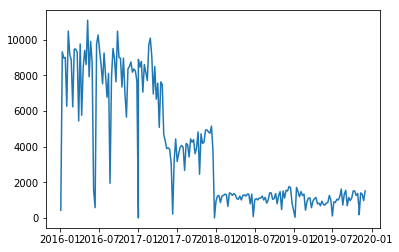

In [4]:
plt.plot(df_PartNo_29032636)

# adfuller Test

* p-value > 0.05, the data has a unit root and is non-stationary.
* d <> 0

In [5]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(df_PartNo_29032636, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Test Statistic                  -1.583772
p-value                          0.491740
#Lags Used                      11.000000
Number of Observations Used    194.000000
Critical Value (1%)             -3.464515
Critical Value (5%)             -2.876556
Critical Value (10%)            -2.574775
dtype: float64


In [5]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(df_PartNo_29032636, nlags=20)
lag_pacf = pacf(df_PartNo_29032636, nlags=20, method='ols')

# Autocorrelation Function (ACF)

* The element of the time-series are highly correlated with each other
* Lags is 1 in-between elements
* q = 1

Text(0.5,1,'Autocorrelation Function')

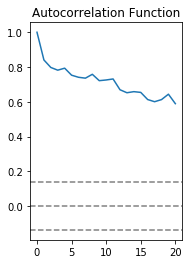

In [7]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_PartNo_29032636)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_PartNo_29032636)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

# Partial Autocorrelation Function (PACF)

* Lags is 2 in-between elements
* p = 1

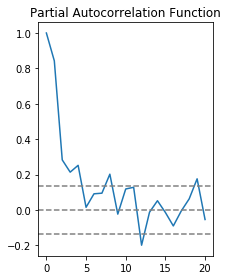

In [8]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_PartNo_29032636)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_PartNo_29032636)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [10]:
df_train = df_PartNo_29032636[:-49]
df_test = df_PartNo_29032636[-49:]

# ARIMA

* Forecasting Demands of PartNo 29032636
* (p,d,q) = (1,1,1)

* Manual Simulate with various combinations is required of (p,d,q) -  for best result using Arima.

In [14]:
model = ARIMA(df_train,order=(1,1,1))
fit = model.fit(disp=0)
pred = fit.forecast(steps=49)
df_test['pred'] = pred[0]

error = sqrt(mean_squared_error(df_test.PartNo_29032636, df_test.pred))
print('Error: ',error)

Error:  1270.5785907487832


# AUTO-ARIMA

* Automating the process of determining the best combination (p,d,q) values for optimum result using Auto-Arima

In [11]:
pred_arima = auto_arima(df_train, 
                        #error_action='ignore', 
                        trace=1,
                        seasonal=False,
                        out_of_sample_size=12,
                        max_order = 5,
                        n_jobs = -1,
                        max_iter = 5,
                        scoring='mse')

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=2802.163, BIC=2820.462, Time=0.883 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=2837.276, BIC=2843.375, Time=0.066 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=2821.570, BIC=2830.720, Time=0.254 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=2803.520, BIC=2812.669, Time=0.400 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=2835.275, BIC=2838.325, Time=0.044 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=2800.512, BIC=2815.761, Time=0.542 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=2798.816, BIC=2811.015, Time=0.341 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=2800.744, BIC=2815.993, Time=0.911 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=2799.092, BIC=2811.291, Time=0.574 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=2800.215, BIC=2818.514, Time=0.960 seconds
Total fit time: 5.000 seconds


In [12]:
pred_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  157
Model:               SARIMAX(0, 1, 2)   Log Likelihood               -1395.408
Date:                Thu, 20 Aug 2020   AIC                           2798.816
Time:                        00:35:37   BIC                           2811.015
Sample:                             0   HQIC                          2803.771
                                - 157                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -35.0565     39.997     -0.876      0.381    -113.449      43.336
ma.L1         -0.5811      0.058    -10.001      0.000      -0.695      -0.467
ma.L2         -0.2098      0.063     -3.337      0.001      -0.333      -0.087
sigma2      3.361e+06   2.39e+05     14.034      0.000    2.89e+06    3.83e+06
===================================================================================
Ljung-Box (Q):                       52.52   Jarque-Bera (JB):               191.75
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               0.04   Skew:                            -0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
df_test['pred'] = np.round(pred_arima.predict(n_periods=49)[:])
df_test.head()

,PartNo_29032636,pred
date,,
2019-01-07,36,978.0
2019-01-14,1710,1040.0
2019-01-21,1476,1005.0
2019-01-28,1188,970.0
2019-02-04,1476,935.0


In [17]:
rms = sqrt(mean_squared_error(df_test.PartNo_29032636, df_test.pred))
rms

1028.0601606314442

* Testing TS Forecasting for all 300+ Parts using Auto-Arima

In [68]:
parts = df.columns[df.columns.str.contains(pat = 'PartNo_')]  
d = {i: pd.DataFrame() for i in parts.values}
    
for name, item in d.items():
    item['date'] = df.date
    item[name] = df[name]
    item.set_index('date',inplace=True)
    #print(item.info(2))
    item[name] = item[name].apply(lambda x: 0 if x == ' ' else x)
    item[name] = item[name].astype(int)
    df_train = item[:-49]
    df_test = item[-49:]
    pred_arima = auto_arima(df_train, 
                            error_action='ignore', 
                            #trace=1,
                            seasonal=False,
                            out_of_sample_size=12,
                            max_order = 5,
                            n_jobs = -1,
                            max_iter = 5,
                            scoring='mse')
    #print(pred_arima.summary())
    df_test['pred_demand'] = pred_arima.predict(n_periods=49)[:]
    rmse = sqrt(mean_squared_error(df_test[name], df_test['pred_demand']))
    print('rmse of '+name+' inventory: ',rmse)

rmse of PartNo_29032636 inventory:  1028.044551080058
rmse of PartNo_29032635 inventory:  1237.6968356828368
rmse of PartNo_29033235 inventory:  1406.5804465608335
rmse of PartNo_29033235.1 inventory:  2844.48436977873
rmse of PartNo_29033234 inventory:  1241.633564734313
rmse of PartNo_29033234.1 inventory:  2844.1399317447567
rmse of PartNo_29032793 inventory:  2955.137195512627
rmse of PartNo_29032794 inventory:  2955.0569229274047
rmse of PartNo_29032588DL inventory:  2639.9337174043912
rmse of PartNo_29032587DL inventory:  2104.231637453735
rmse of PartNo_29032639 inventory:  709.51447907202
rmse of PartNo_29032639.1 inventory:  994.4378069492712
rmse of PartNo_29032640 inventory:  700.2370016138663
rmse of PartNo_29032640.1 inventory:  977.1048005339202
rmse of PartNo_29032815 inventory:  926.6706128932199
rmse of PartNo_29032814 inventory:  927.3635112682952
rmse of PartNo_29032527DL inventory:  820.340921671797
rmse of PartNo_29032526DL inventory:  819.9096683392114
rmse of Par

rmse of PartNo_29032408.3 inventory:  18.20034161485074
rmse of PartNo_29032407 inventory:  94.97623458210562
rmse of PartNo_29032407.1 inventory:  12.454937556239036
rmse of PartNo_29032407.2 inventory:  0.7284313590846836
rmse of PartNo_29032407.3 inventory:  25.5873597883202
rmse of PartNo_29032615DL inventory:  172.56124401889699
rmse of PartNo_29032616DL inventory:  172.32460165681564
rmse of PartNo_29032671 inventory:  159.00382171913486
rmse of PartNo_29033256 inventory:  1179.6027954790718
rmse of PartNo_29033257 inventory:  1180.366459872457
rmse of PartNo_29033019 inventory:  144.13263006913104
rmse of PartNo_29033020 inventory:  144.13263006913104
rmse of PartNo_29033064 inventory:  547.228332491296
rmse of PartNo_29033064.1 inventory:  0.0
rmse of PartNo_29033064.2 inventory:  96.0229564909732
rmse of PartNo_29033064.3 inventory:  0.8692911128320003
rmse of PartNo_29033065 inventory:  547.228332491296
rmse of PartNo_29033065.1 inventory:  0.0
rmse of PartNo_29033065.2 inven

rmse of PartNo_29033252 inventory:  3.7552684340276095
rmse of PartNo_29033252.1 inventory:  2.142857159527187
rmse of PartNo_29033252.2 inventory:  0.42857144524148555
rmse of PartNo_29033253 inventory:  3.7552684340276095
rmse of PartNo_29033253.1 inventory:  2.142857159527187
rmse of PartNo_29033253.2 inventory:  0.42857144524148555
rmse of PartNo_29033267 inventory:  3.0871690117089092
rmse of PartNo_29033268 inventory:  3.0871690117089092
rmse of PartNo_29033333 inventory:  4.285714302384329
rmse of PartNo_29033332 inventory:  4.285714302384329
rmse of PartNo_29033236 inventory:  2.927697449736445
rmse of PartNo_29033237 inventory:  2.927697449736445
rmse of PartNo_32054032 inventory:  2.2901742462649888
rmse of PartNo_32054033 inventory:  2.2901742462649888
rmse of PartNo_29033319 inventory:  2.7774603198956025
rmse of PartNo_29033320 inventory:  2.7774603198956025
rmse of PartNo_29932222 inventory:  0.2221374518734131
rmse of PartNo_29033110 inventory:  0.42594338853733466
rmse 

# Building 12 week Time Series Forecast models

* Calculating dates for the next 12 weeks.
* Forecasting Demands - using Auto-Arima
* Replacing negative demand forecasts with 0
* Calculating corresponding week numbers, for reference

In [54]:
import datetime

i=0
week=12
start_dt = datetime.datetime(2019, 12, 8)

dt_list = [str(start_dt.date())]
while(i<(int(week)-1)):
    nxt_dt = start_dt+datetime.timedelta(days=7)
    dt_list.append(str(nxt_dt.date()))
    start_dt=nxt_dt
    i+=1
forecasted_data = pd.DataFrame(dt_list,columns=['date'])
forecasted_data.date = pd.to_datetime(forecasted_data.date)
forecasted_data.head(2)

,PartNo_29032636,PartNo_29032635,PartNo_29033235,PartNo_29033235.1,PartNo_29033234,PartNo_29033234.1,PartNo_29032793,PartNo_29032794,PartNo_29032588DL,PartNo_29032587DL,...,PartNo_29033341,PartNo_29033354,PartNo_29033355,PartNo_29033216,PartNo_18345618,PartNo_29033217,PartNo_18345617,PartNo_29033215,PartNo_29033214,date
0,1105,1105,3640,8108,3691,8110,2692,2692,0,0,...,0,0,0,0,0,0,0,0,0,2019-12-08
1,969,970,3182,7931,3129,7934,2696,2696,0,0,...,0,0,0,0,0,0,0,0,0,2019-12-15


In [40]:
parts = df.columns[df.columns.str.contains(pat = 'PartNo_')]  
d = {i: pd.DataFrame() for i in parts.values}

for name, item in d.items():
    print('Forecasting for '+name+' inventory demands')
    item['date'] = df['date']
    item[name] = df[name]
    item.set_index('date',inplace=True)
    
    item[name] = item[name].apply(lambda x: 0 if x == ' ' else x)
    item[name] = item[name].astype(int)
    df_train = item[name]
    #df_train = item[:-12]
    #df_test = item[-12:]
    pred_arima = auto_arima(df_train, 
                            error_action='ignore', 
                            #trace=1,
                            seasonal=False,
                            out_of_sample_size=12,
                            max_order = 5,
                            n_jobs = -1,
                            max_iter = 5,
                            scoring='mse')
    #print(pred_arima.summary())
    forecasted_data[name] = pred_arima.predict(n_periods=week)[:]

Forecasting for PartNo_29032636 inventory demands
Forecasting for PartNo_29032635 inventory demands
Forecasting for PartNo_29033235 inventory demands
Forecasting for PartNo_29033235.1 inventory demands
Forecasting for PartNo_29033234 inventory demands
Forecasting for PartNo_29033234.1 inventory demands
Forecasting for PartNo_29032793 inventory demands
Forecasting for PartNo_29032794 inventory demands
Forecasting for PartNo_29032588DL inventory demands
Forecasting for PartNo_29032587DL inventory demands
Forecasting for PartNo_29032639 inventory demands
Forecasting for PartNo_29032639.1 inventory demands
Forecasting for PartNo_29032640 inventory demands
Forecasting for PartNo_29032640.1 inventory demands
Forecasting for PartNo_29032815 inventory demands
Forecasting for PartNo_29032814 inventory demands
Forecasting for PartNo_29032527DL inventory demands
Forecasting for PartNo_29032526DL inventory demands
Forecasting for PartNo_29032751 inventory demands
Forecasting for PartNo_29032752 in

Forecasting for PartNo_29033256 inventory demands
Forecasting for PartNo_29033257 inventory demands
Forecasting for PartNo_29033019 inventory demands
Forecasting for PartNo_29033020 inventory demands
Forecasting for PartNo_29033064 inventory demands
Forecasting for PartNo_29033064.1 inventory demands
Forecasting for PartNo_29033064.2 inventory demands
Forecasting for PartNo_29033064.3 inventory demands
Forecasting for PartNo_29033065 inventory demands
Forecasting for PartNo_29033065.1 inventory demands
Forecasting for PartNo_29033065.2 inventory demands
Forecasting for PartNo_29033065.3 inventory demands
Forecasting for PartNo_29032997 inventory demands
Forecasting for PartNo_29032996 inventory demands
Forecasting for PartNo_29032427DP inventory demands
Forecasting for PartNo_29032427DP.1 inventory demands
Forecasting for PartNo_29032428DP inventory demands
Forecasting for PartNo_29032428DP.1 inventory demands
Forecasting for PartNo_29033234PB inventory demands
Forecasting for PartNo_2

Forecasting for PartNo_29033320 inventory demands
Forecasting for PartNo_29932222 inventory demands
Forecasting for PartNo_29033110 inventory demands
Forecasting for PartNo_29033111 inventory demands
Forecasting for PartNo_29033296 inventory demands
Forecasting for PartNo_29033295 inventory demands
Forecasting for PartNo_29033340 inventory demands
Forecasting for PartNo_29033341 inventory demands
Forecasting for PartNo_29033354 inventory demands
Forecasting for PartNo_29033355 inventory demands
Forecasting for PartNo_29033216 inventory demands
Forecasting for PartNo_18345618 inventory demands
Forecasting for PartNo_29033217 inventory demands
Forecasting for PartNo_18345617 inventory demands
Forecasting for PartNo_29033215 inventory demands
Forecasting for PartNo_29033214 inventory demands


In [41]:
for name, item in d.items():
    forecasted_data[name] = forecasted_data[name].apply(lambda x: int(x) if x >= 0 else 0)

In [55]:
forecasted_data['week'] = forecasted_data['date'].apply(lambda x: x.strftime("%U"))
forecasted_data.head()

,PartNo_29032636,PartNo_29032635,PartNo_29033235,PartNo_29033235.1,PartNo_29033234,PartNo_29033234.1,PartNo_29032793,PartNo_29032794,PartNo_29032588DL,PartNo_29032587DL,...,PartNo_29033354,PartNo_29033355,PartNo_29033216,PartNo_18345618,PartNo_29033217,PartNo_18345617,PartNo_29033215,PartNo_29033214,date,week
0,1105,1105,3640,8108,3691,8110,2692,2692,0,0,...,0,0,0,0,0,0,0,0,2019-12-08,49
1,969,970,3182,7931,3129,7934,2696,2696,0,0,...,0,0,0,0,0,0,0,0,2019-12-15,50
2,910,911,3624,7970,3665,7974,2699,2699,0,0,...,0,0,0,0,0,0,0,0,2019-12-22,51
3,873,874,3241,8009,3195,8013,2703,2703,0,0,...,0,0,0,0,0,0,0,0,2019-12-29,52
4,842,843,3615,8048,3647,8052,2706,2707,0,0,...,0,0,0,0,0,0,0,0,2020-01-05,01


* Forecasted next 12 weeks demands for all Parts is saved in Parts_Inventory_Forecasting document in  Data folder, for reference.

In [56]:
forecasted_data.to_excel('Data/Parts_Inventory_Forecasting.xlsx')